# Кто выбирает президентов

# Часть 4: Построение тематической модели

In [144]:
import pandas as pd              # Пакет для работы с таблицами
import numpy as np               # Пакет для работы с векторами и матрицами

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

# Из библиотеки для работы с текстами вытащим 
# методы для  предобработки и модели
from gensim import corpora, models

# Пара дополнительных комбинаторных штук для картинок
from collections import defaultdict
import itertools   

# Пакет, чтобы делать глубокие копии
import copy

# Пакет для работы со специфичными для питона данными
import pickle

# Косинусная метрика для рассчёта расстояний 
from scipy.spatial.distance import cosine

In [2]:
%matplotlib inline  

# 1. Что такое тематическое моделирование

Пришло время обсудить то, как именно рождаются тексты. Разговаривать об этом мы будем не особо глубоко. Нашей задачей является понять то, что именно нам выдаст на выходе алгоритм. То какие именно тонкости за ним стоят и как происходит оценивание, мы опустим. Подробнее о них вы можете узнать, например [в третьем курсе специализации по машинному обучению от Яндекса и МФТИ.](https://www.coursera.org/learn/unsupervised-learning/home/welcome) 

Итак, отбросим прочь все предрассудки и глупости. Наши мир создал он, __великий процесс порождения данных!__ И каждый текст он создал в виде мешка. Мешка слов. На самом деле мешков много. И каждый мешок соответствует своей теме. Внутри мешков лежат камушки. Много камушков. На каждом камушке написано какое-то слово. Слова часто повторяются. Каждое слово повторяется разное количество раз. 

<img align="center" src=" pictures/meshok_1.png" width="600"> 

Дальше природа подкидывает кубик с количеством граней равным количеству тем и выбирает одну из них. Кубик у природы неправильный. Разные грани выпадают на нём с разными вероятностями. Из мешка, который соответствует этой теме, природа тянет камушек.

<img align="center" src="pictures/meshok_2.png" width="450"> 

После природа подкидывает кубик снова, выбирает какую-то новую тему и начинает тянуть из мешка, который ей соответствует, новый камушек. Так и рождается текст.

Поговорим о порождении природой текстов чуть более научно. Будем называть каждый текст **документом, $d$.** Каждый документ состоит из нескольких **тем, $t$.** Каждая тема описывается некоторым набором **слов, $w$.**

Как мы выяснили выше, каждый документ — это мешок слов. Для каждого слова мы можем посчитать с какой частотой оно входит в каждый документ. Эта частота будет оценкой вероятности встретить в документе конкретное слово, $p(w \mid d)$. В конечном счёте, мы видим матрицу, где по строкам откладываются конкретные слова, по столбцам документы, а на пересечении стоят частоты, с которыми наши слова встречаются в документах.

<img align="center" src="pictures/matrix1.png" width="300"> 


Мы хотели бы научиться выделять в каждом документе темы. Руководствуясь этим желанием, мы можем сказать, что процесс порождения текстов описывается следующим образом. Есть какое-то, изначально задуманной природой, количество тем, $T$. Для каждого документа существует некоторое распределение тем в нём, $p(t | d) = \theta_{td}$. Природа случайно выбирает из него одну из тем. После из распределения слов $p(w | t) = \phi_{wt}$, которое соответствует выбранной теме, выбирается слово. Именно оно и попадает в текст.

<img align="center" src="pictures/doc_generate.png" width="1100"> 

Обратите внимание, что каждое слово втыкается в документ независимо от того какие слова были туда запиханы до него (мешок слов). Греческие буквы для обозначения этих вероятностей используются для удобства.

В конечном счёте получается, что мы можем встретить слово $w$ в документе $d$, если оно выскочило к нам из темы $t_1$ или из темы $t_2$ и так далее. Возникает $T$ гипотез возникновения слова в документе. Полная вероятность появления слова может быть вычислена по формуле полной вероятности.

$$
p(w | d) = \sum_{t \in T} p(w | t) \cdot p(t |d) = \sum_{t \in T} \phi_{wt} \cdot \theta_{td}
$$

Вся матрица слова на документы таким образом может быть разложена в произведение из двух более маленьких матриц. 


<img align="center" src="pictures/matrix.png" width="700"> 

В матрице $\Phi$ по строкам расположены слова, по столбцам темы. На пересечении стоит вероятность встретить слово из строки в теме из столбца. В матрице $\Theta$ по строкам находятся темы, по столбцам документы. На пересечении стоит вероятность встретить тему из строки в документе из столбца. При перемножении каждой строки на каждый столбец, получается ровно требуемая нам полная вероятность встретить слово $w$ в документе $d$.

Если говорить обо всём этом в терминах мешков, в матрице $Θ$ лежат вероятности вытянуть камушки с конкретными словами. В матрице $Φ$ лежат вероятности, с которыми кубик выпадает разными гранями.

Вероятности из матриц $\Phi$ и $\Theta$ неизвестны. Наша задача сводится к тому, чтобы как-то их оценить. Такая задача носит название **задачи матричного разложения.** Человечество неплохо умеет её решать. Если говорить совсем грубо, то на неизвестные коэффициенты матриц накладываются ограничения, дальше выписывается целевая функция и лагранджиан для неё. Потом минимизацию делают с помощью градиентного спуска.

Именно на решении такой задачи основаны многие рекомендательные системы в интернет-магазинах и на сайтах. Если говорить чуть менее грубо, то, обычно, всё сводится к максимизации правдоподобия. Более того, есть даже специальные методы наименьших квадратов, которые решают эту задачу.

Стоит сказать, что сама по себе, задача матричного разложения не имеет единственного решения. Если между нашими матрицами впихнуть ещё одну, мы получим новое решение.

$$ ΦΘ = (ΦS)(S^{−1}Θ) = Φ^1Θ^1 $$

Из-за этого приходится вводить какие-то дополнительные ограничения на структуру матриц. Введение таких ограничений называется **регуляризацией.** На самом деле есть разные ограничения на коэффициенты матриц. Одни из них пытаются сделать темы независимее друг от друга, другие пытаются выделить фоновую лексику, третьи пытаются сделать матрицы более разряженными. Для всего этого есть даже [ультра крутая библиотека ARTM.](https://www.youtube.com/watch?v=H7hlSz4WWhQ)

Самым знаменитой регуляризацией является регуляризация Дирихле, которую придумали в 2003 году. Именно её мы и будем использовать.

** Ещё раз, ещё раз:** Мы хотим оценить вероятность появления каждого слова в каждой теме и каждой темы в каждой группе. Число тем мы будем задавать сами. Для решения этой задачи мы будем использовать модель с регуляризатором Дирихле, которая носит имя LDA.

# 2. Латентное распределение Дирихле (LDA) 

Вот тут лежит лучший друг человека, [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

## 2.1 Создание словоря и корпуса

In [3]:
# Подгружаем табличку с отлемматизированными данными
df_text_lemm = pd.read_csv('data_text_lemm.csv', sep=';')
df_text_lemm.head()

,uid,candidat_name,lemm_text
0,145578958,Putin,"['друг', 'встречаться', 'сегодня', '19', '00',..."
1,145579153,Putin,"['это', 'вещь', 'собрать', 'осадный', 'мортира..."
2,145580272,Putin,"['конкурс', '15', 'рандомный', 'ключ', 'steam'..."
3,145580416,Putin,"['сметь', 'думать', 'мочь', 'выдержать', 'эрне..."
4,145581817,Putin,"['художник', 'ринат', 'волигамси', 'большой', ..."


Итак, для начала попробуем воспользоваться для кластеризации групп по контенту библиотекой `gensim`, внутри которой лежит довольно популярный для этих целей алгоритм под названием LDA. Для его работы коллекция документов должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

```[["hello", "world"], ["programming", "in", "python"]]```

Мы заранее именно в таком виде всё и сохранили. Cоздадим объекты `corpus` и `dictionary`, с которыми будет работать модель.

In [4]:
texts = [eval(tx) for tx in df_text_lemm.lemm_text.get_values()]
texts[0][:10]

['друг',
 'встречаться',
 'сегодня',
 '19',
 '00',
 'трк',
 'лотос',
 'plaza',
 'горячо',
 'красиво']

В векторах часто встречаются цифры, а также всякие мусорные слова из 2-3 символов. Проведём дополнительную фильтрацию по таким словам и оставим только те, длина которых более 4 символов. 

In [5]:
texts_short = [ ]
for tx in texts:
    texts_short.append([t for t in tx if len(t) > 4])

texts = texts_short

In [6]:
%%time
dictionary = corpora.Dictionary(texts)                 # составляем словарь из терминов
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

CPU times: user 4min 16s, sys: 7.88 s, total: 4min 23s
Wall time: 4min 25s


В векторе `corpus` лежит то сколько раз какое слово встречается в векторе `texts`. Например, нулевое слово встречается 5 раз. Соответствие каждого индекса конкретному слову лежит в словаре `dictionary`.

In [7]:
print(texts[0][:12])
print(corpus[0][:12])

['встречаться', 'сегодня', 'лотос', 'plaza', 'горячо', 'красиво', 'позажигать', 'спасибо', 'участник', 'организатор', 'свадебный', 'выставка']
[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2)]


In [8]:
# Посмотрим на размер нашего словоря (число уникальных слов)
print('Количество уникальных слов: {}'.format(len(dictionary)))

Количество уникальных слов: 2026732


Интересно было бы узнать какие слова встречаются в группах очень часто, а какие очень редко. Для того, чтобы узнать это, построим красивую картиночку.

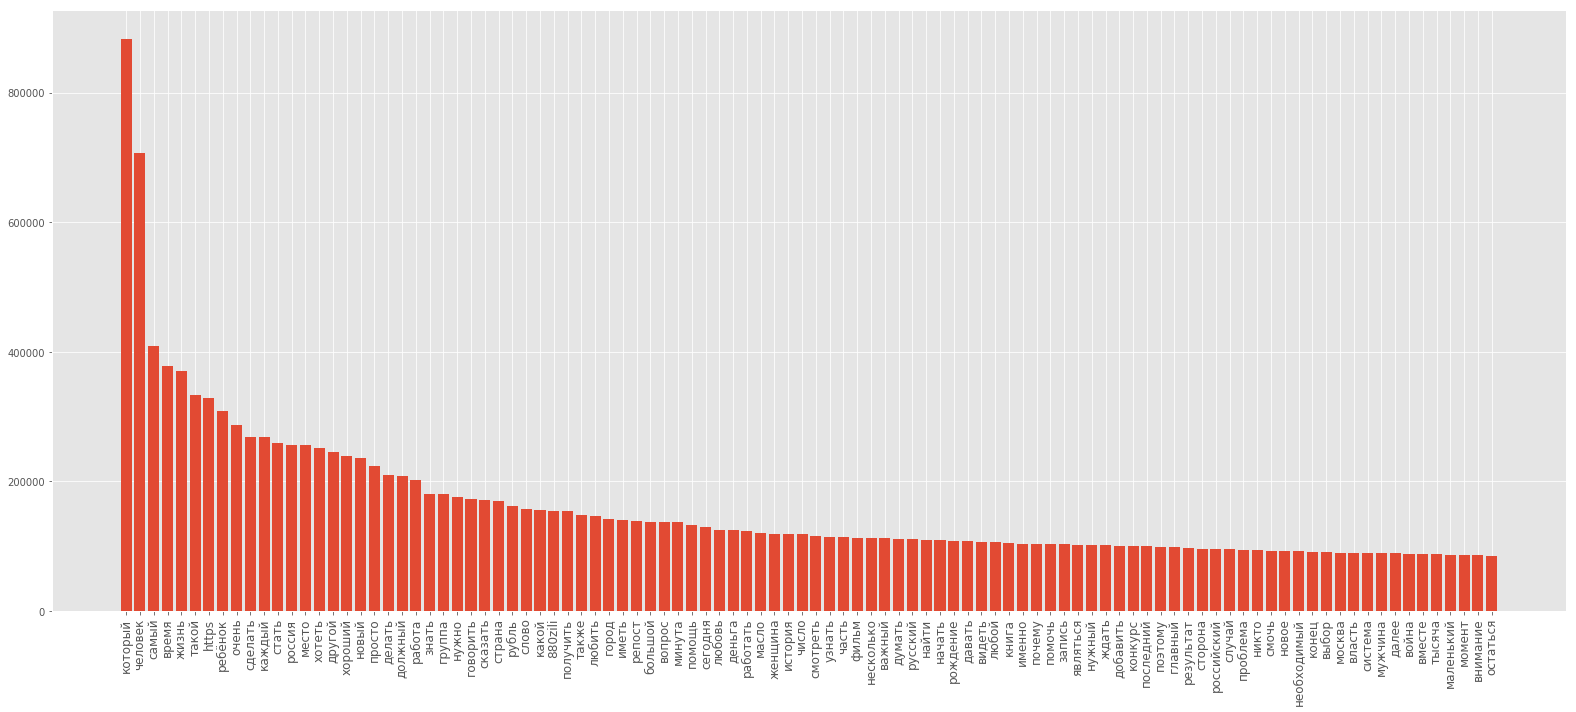

In [9]:
def word_freq_plot(dictionary, corpus, k=100):
    """
        Строит график с частотами слов из корпуса
        dictionary: dict
            словарь с уникальными терминами из corpora
        corpus: list
            корпус из слов из corpora 
        
        parameters:
        k : int
            количество слов, по которому нужно построить график  
    """
    
    # Создаём по всем текстам словарик с частотами
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus):
        total_word_count[dictionary.get(word_id)] += word_count

    # Сортируем словарик по частотам
    sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)     
    
    # Делаем срез и по этому срезу строим картиночку 
    example_list = sorted_word_count[:k]
    word = []
    frequency = []
    for i in range(len(example_list)):
        word.append(example_list[i][0])
        frequency.append(example_list[i][1])

    indices = np.arange(len(example_list))
    
    plt.figure(figsize=(22,10))
    plt.bar(indices, frequency)
    plt.xticks(indices, word, rotation='vertical',fontsize=12)
    plt.tight_layout()
    pass

word_freq_plot(dictionary, corpus)

На стадии предобработки мы постарались отсеять часть стоп-слов. Тем не менее, многие такие слова не вошли в список для филтрации. Также в этот список не попали цифры. Проведём дополнительную фильтрацию по частоте и отсеим очень часто встречающиеся специфические слова с помощью фильтрации словоря. 

In [10]:
dictionary_2 = copy.deepcopy(dictionary)  # На всякий случай скопируем словарь
dictionary_2.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)

In [11]:
print('Размер словоря до фильтрации: {}'.format(len(dictionary)))
print('Размер словоря после фильтрации: {}'.format(len(dictionary_2)))

Размер словоря до фильтрации: 2026732
Размер словоря после фильтрации: 445956


CPU times: user 2min 54s, sys: 21.5 s, total: 3min 16s
Wall time: 3min 20s


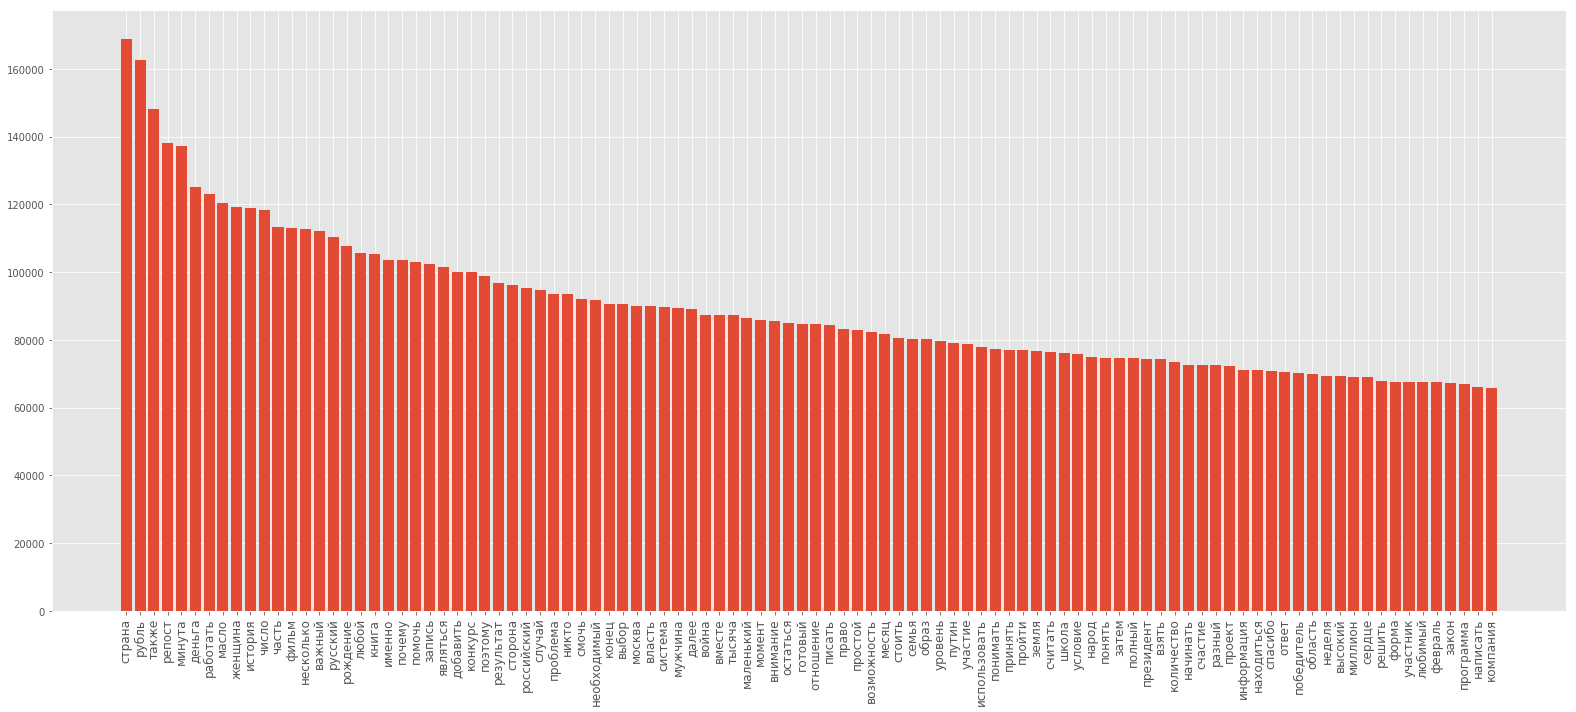

In [13]:
%%time
# Создаём корпус и рисуем картиночку 
corpus_2 = [dictionary_2.doc2bow(text) for text in texts]
word_freq_plot(dictionary_2 , corpus_2)

Отлично! По такому словарику уже можно строить модель. Попробуем обучить LDA модель с 20 темами. Будем проходить по коллекции 20 раз. Остальные параметры пока что установим по умолчанию. Заодно выясним как долго наша модель собирается учиться. 

## 2.2 Наша первая LDA-модель 

Чтобы оценить LDA-модель, нужно запустить код ниже и подождать около $1.5$ часов. 

In [ ]:
# %%time
# np.random.seed(42)
# ldamodel_20 = models.ldamodel.LdaModel(corpus_2, id2word=dictionary_2, num_topics=20, passes=10)

Ура! Наша модель обучилась. Обучение шло около двух часов. Сохраним модель на свой комп, чтобы в случае чего просто подгрузить её.

In [ ]:
# Сохранение модели
# ldamodel_20.save("lda_models/ldamodel_20")

In [14]:
# Загрузка модели
ldamodel_20 = models.ldamodel.LdaModel.load("lda_models/ldamodel_20")

Теперь мы можем посмотреть для каждого документа распределение по темам. Например, для первого документа оно выглядит вот так: 

In [17]:
ldamodel_20.get_document_topics(corpus_2[299])

[(0, 0.2333132),
 (3, 0.075008102),
 (10, 0.094699748),
 (11, 0.15380329),
 (13, 0.051562123),
 (14, 0.10925125),
 (16, 0.18450598),
 (19, 0.092938274)]

Также можно посмотреть на самые вероятные слова для каждой темы. Выведем 10 самых вероятных слов для первых пяти тем. 

In [22]:
topics = ldamodel_20.show_topics(num_topics=20, num_words=20,formatted=False)
i = 0
for top in topics:
    print(i, [item[0] for item in top[1]],'\n')
    i += 1

0 ['альбом', 'музыка', 'концерт', 'песня', 'билет', 'команда', 'песнь', 'москва', 'музыкальный', 'музыкант', 'играть', 'релиз', 'фильм', 'спасибо', 'видео', 'выйти', 'также', 'сцена', 'фестиваль', 'название'] 

1 ['автомобиль', 'система', 'использовать', 'материал', 'необходимый', 'двигатель', 'также', 'часть', 'машина', 'конструкция', 'случай', 'поверхность', 'километр', 'стена', 'скорость', 'установка', 'сантиметр', 'размер', 'устройство', 'труба'] 

2 ['организм', 'вещество', 'заболевание', 'средство', 'также', 'продукт', 'болезнь', 'кровь', 'лечение', 'клетка', 'волос', 'являться', 'система', 'препарат', 'витамин', 'здоровье', 'масло', 'помогать', 'действие', 'использовать'] 

3 ['рождение', 'открытка', 'голубь', 'хуесос', 'картинка', 'ссылка', 'отправить', 'ответ', 'ad_id', 'приложение', 'уровень', 'привет', 'поздравление', 'играть', 'красивый', 'пройти', 'поздравлять', 'помочь', 'top_cards', 'заходить'] 

4 ['фильм', 'книга', 'история', 'роман', 'подборка', 'герой', 'читать', 'др

Немного поразмышляем о получившихся результатах. В целом кластеры получились чуть более чем интерпретируемы. Когда я просматривал самые вероятные слова и самые вероятные группы для каждого кластера из списка выше, я пару раз ловил себя на мысли, что неплохо бы увеличить их число. Попробуем обучить аналогичную модель с 30 топиками.

Код для обучения модели мы запускать сейчас не будем. Это ещё около двух часов. Подгрузим сразу уже готовые веса. 

In [ ]:
# %%time
# np.random.seed(42)
# ldamodel_30 = models.ldamodel.LdaModel(corpus_2, id2word=dictionary_2, num_topics=30, passes=15)

In [ ]:
# Сохранение модели
# ldamodel_30.save("lda_models/ldamodel_30")

In [18]:
# Загрузка модели
ldamodel_30 = models.ldamodel.LdaModel.load("lda_models/ldamodel_30")

In [19]:
topics = ldamodel_30.show_topics(num_topics=30, num_words=20,formatted=False)
i = 0
for top in topics:
    print(i, [item[0] for item in top[1]],'\n')
    i += 1

0 ['альбом', 'музыка', 'концерт', 'песня', 'хуесос', 'песнь', 'музыкант', 'билет', 'музыкальный', 'фильм', 'релиз', 'видео', 'выйти', 'москва', 'играть', 'сцена', 'запись', 'также', 'исполнитель', 'выпустить'] 

1 ['организм', 'вещество', 'заболевание', 'продукт', 'кровь', 'препарат', 'лечение', 'средство', 'болезнь', 'клетка', 'витамин', 'также', 'система', 'здоровье', 'содержимый', 'действие', 'кислота', 'свойство', 'желудок', 'полезный'] 

2 ['автомобиль', 'система', 'материал', 'необходимый', 'использовать', 'двигатель', 'также', 'часть', 'размер', 'случай', 'машина', 'конструкция', 'сантиметр', 'стена', 'поверхность', 'труба', 'километр', 'являться', 'установка', 'высота'] 

3 ['открытка', 'рождение', 'картинка', 'отправить', 'ответ', 'ad_id', 'приложение', 'ссылка', 'поздравление', 'красивый', 'top_cards', 'fotomimi', 'fotomagic_su', 'from_id', 'привет', 'android', 'megatest', 'подарок', 'переходить', 'love1v'] 

4 ['книга', 'история', 'автор', 'учёный', 'наука', 'читать', 'совре

In [27]:
# Сохраним топики для крутых визуализаций, которые мы будем делать в дальнейшем 
topics = ldamodel_30.show_topics(num_topics=30, num_words=100,formatted=False)

# Сохраняем словарик с id пользователей
with open('lda_30_topics', 'wb') as f:
    pickle.dump(topics, f)

# 2. LDA  - вероятностная модель

Как мы уже говорили выше, матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые группы и новый контент для них.

In [20]:
def generate_content(model, num_words):
    """
        Генерирует контент типичного подписчика политических пабликов 
        model:
            lda-модель, используемая для генерации
        num_words int:
            длина поста (число слов)
    """
    
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_words):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(0, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        # Тут есть костыль. Он делается, чтобы вероятности в сумме давали 1, а не 0.9999999
        w = np.random.choice(terms, p=1/sum(topic_distr)*np.array(topic_distr))
        print(w)

In [21]:
generate_content(ldamodel_20, 20)

энергетика
канал
болливуд
также
kaleidoscope
galat
москва
классический
вообще
побрать
премия
декабрь
линдеманна
мрачный
гений
eurodance
официальный
young
часть
огонь


Если обучить LDA на большом корпусе из ниров, можно будет заставить её написать за вас НИР. Скорее всего, он выйдет не очень качественным. Обычно, когда хотят что-то сгенерировать, используют более сложные модели, связанные с нейросетями.  Уже было [несколько скандалов](https://habrahabr.ru/post/213891/) связанных с тем, что какие-то чуваки нагенерировали ненастоящих статей, а журналы их опубликовали.

Например, в России [в публикацию попала статья](http://polit.ru/article/2009/04/01/erunda/) «Корчеватель: алгоритм типичной унификации точек доступа и избыточности». Вроде бы её название звучит, как нечто ультраглубокое и годное... 

# 4. Тематические профили подписчиков


В дальнейшем будем работать с кластеризацией на 30 тем. Она выделила их более круто и интерпретируемо. Если попробовать вглядеться в самые популярные слова каждого топика, то можно придумать одно ёмкое слово для его описания. Вглядимся в такие топики и присвоим названия каждому из них. 

In [131]:
themes_30 = {
 0 : 'билеты на концерты',                   1 : 'лекарства, болезни', 
 2 : 'автомобили, строительство',            3 : 'поздравления, открытки',
 4 : 'книги, наука',                         5 : 'отношения',          
 6 : 'буряты',                               7 : 'английский язык',
 8 : 'законы, право',                        9 : 'скороговорки',       
 10: 'животные, приюты',                     11: 'цены на лекарства',
 12: 'уход за ребёнком',                     13: 'война', 
 14: 'конкурсы, розыгрыши',                  15: 'рецепты',
 16: 'игры в vk',                            17: 'сбор средств на лечение',           
 18: 'спорт, тренировки',                    19: 'оружие',
 20: 'политика',                             21: 'семейные отношения',     
 22: 'художественная литература, фильмы',    23: 'украина',
 24: 'спортивные мероприятия',               25: 'бизнес',   
 26: 'музеи, кудаGo',                        27: 'кулстори, пикабу',
 28: 'ваниль, чувства',                      29: 'современная музыка' 
}

Построим для каждого кандидата тематический профиль. 

In [132]:
def candidatPeofile(model, candidate, corpus):
    """
        Возвращает тематический профиль, соответствующий кандидату
        model: 
            lda-модель
        candidate: str
            Фамилия кандидата
    """
    # Тут будем хранить результат
    theme_results = [ ]

    # Какое в модели количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соовтетствуют текущему кандидату
    num = df_text_lemm[df_text_lemm.candidat_name == candidate].index.get_values() - 1

    # Вектор для тематического профиля кандидата
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем сторонникам текущего кандидата
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    print('Доля битых профилей для {}:'.format(candidate), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

candidate_themes = { }
for candidate in df_text_lemm.candidat_name.unique():
    
    # Выделяем темы для текущего кандидата
    theme = candidatPeofile(ldamodel_30, candidate, corpus_2)
    
    # Записываем их в словарик:
    candidate_themes[candidate] = theme

Доля битых профилей для Putin: 0.0
Доля битых профилей для Grudinin: 0.0
Доля битых профилей для Baburin: 0.0
Доля битых профилей для Titov: 0.0
Доля битых профилей для Sobchak: 0.0
Доля битых профилей для Suraykin: 0.0
Доля битых профилей для Yavlinskiy: 0.0
Доля битых профилей для Zhirinovsky: 0.0
Доля битых профилей для Navalny: 0.005972503944106378


In [133]:
# Сохраняем словарик с тематическими профилями кандидатов
with open('candidate_themes', 'wb') as f:
    pickle.dump(candidate_themes, f)

In [166]:
def profilePlot(theme_profile, candidate, themes=themes_30):
    """
    Строит тематическией профиль для каждого кандидата
    theme_profile:
        тематический профиль, dict
    candidate: 
        фамилия кандидата
    
    parameters:
        themes dict:
            названия тем
    """
    
    theme_profile = theme_profile[candidate]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    print('Тематический профиль для {}: \n'.format(candidate))
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(30, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,30)
    
    them = [themes[pr[0]] for pr in sorted_prof]
    sns.heatmap(prof, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    pass

Тематический профиль для Putin: 



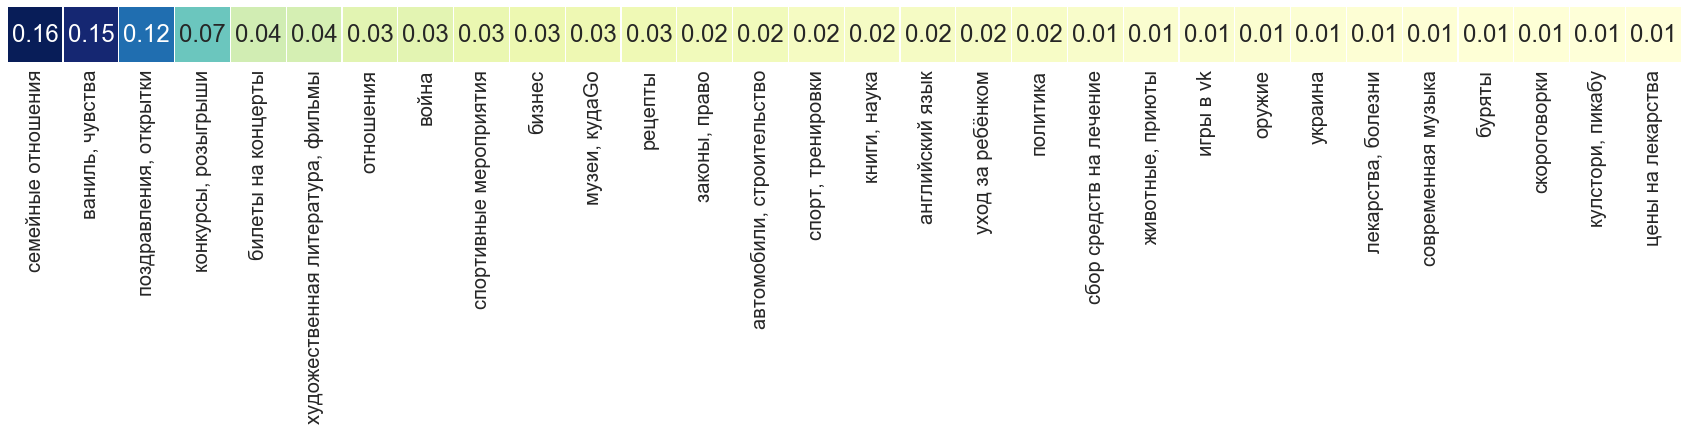

In [135]:
profilePlot(candidate_themes, 'Putin')

Тематический профиль для Grudinin: 



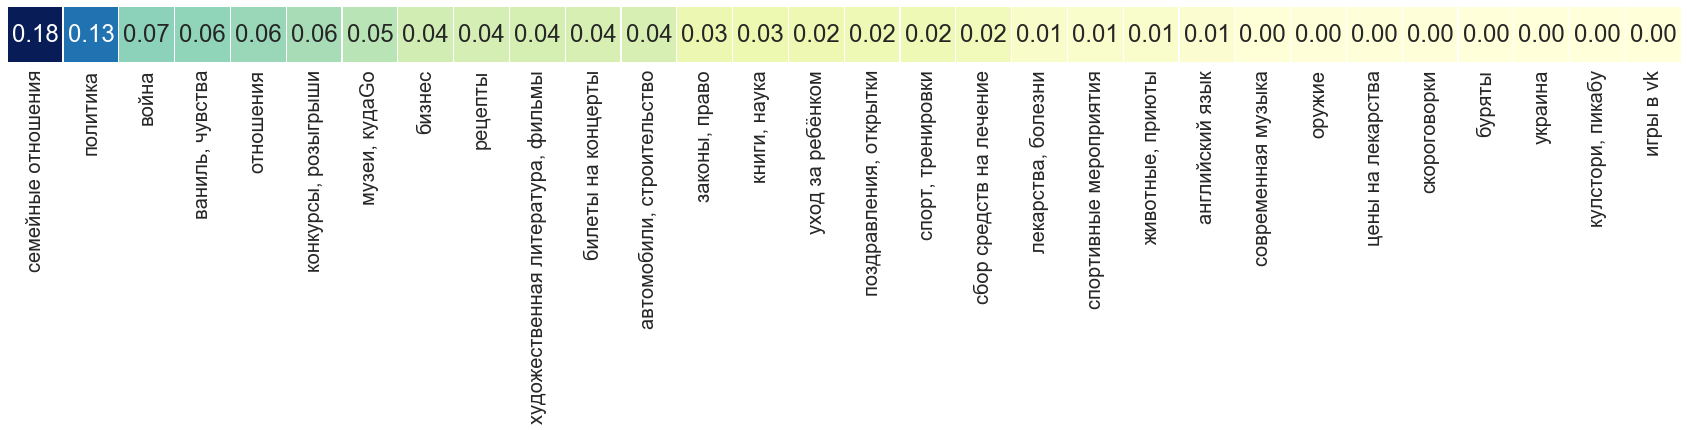

In [136]:
profilePlot(candidate_themes, 'Grudinin')

Тематический профиль для Navalny: 



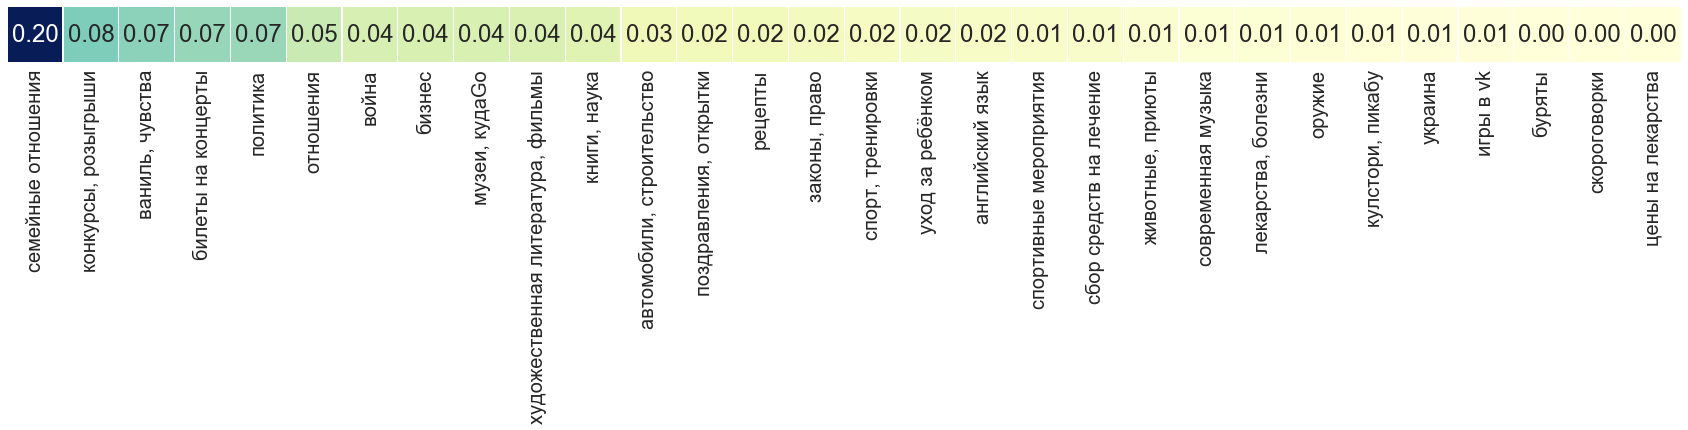

In [137]:
profilePlot(candidate_themes, 'Navalny')

Тематический профиль для Sobchak: 



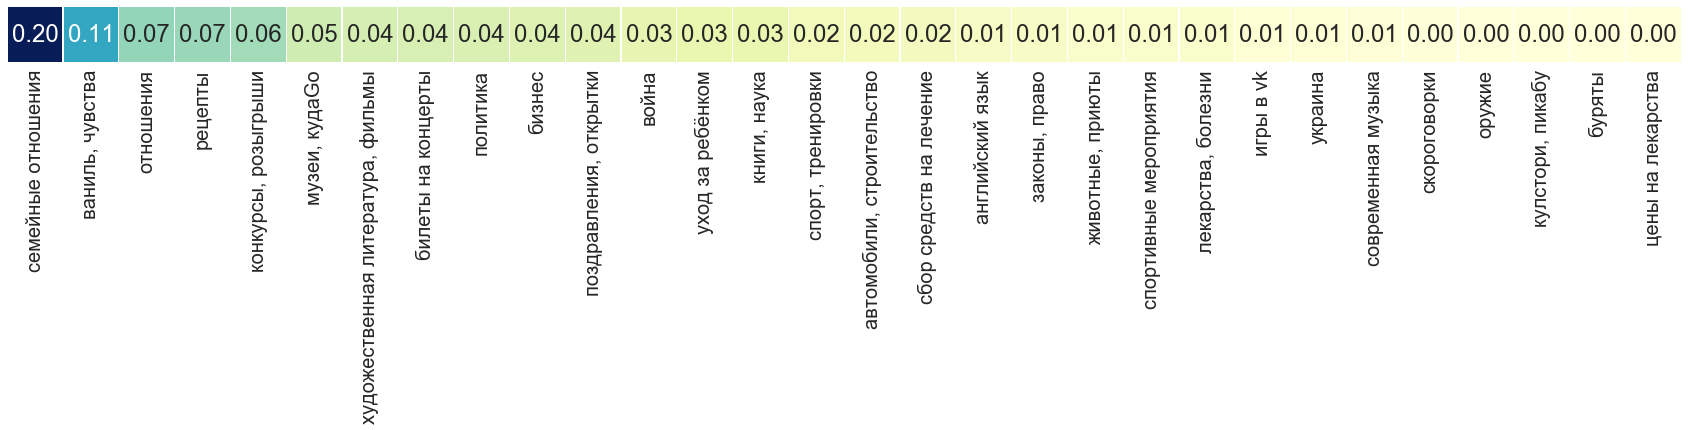

In [138]:
profilePlot(candidate_themes, 'Sobchak')

Тематический профиль для Zhirinovsky: 



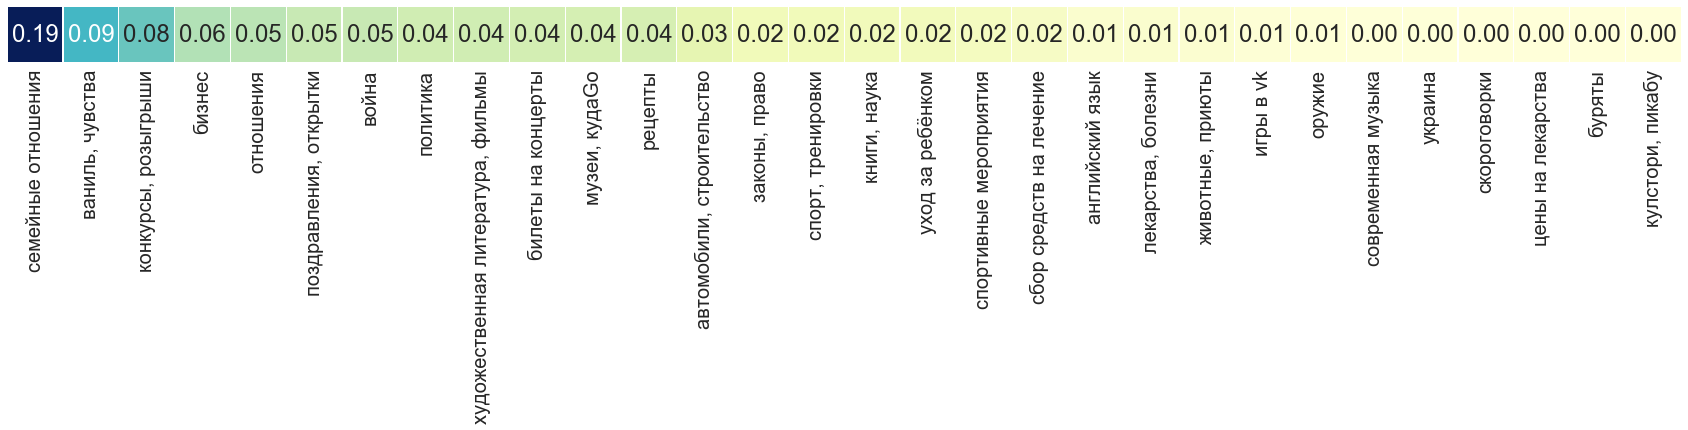

In [139]:
profilePlot(candidate_themes, 'Zhirinovsky')

Тематический профиль для Yavlinskiy: 



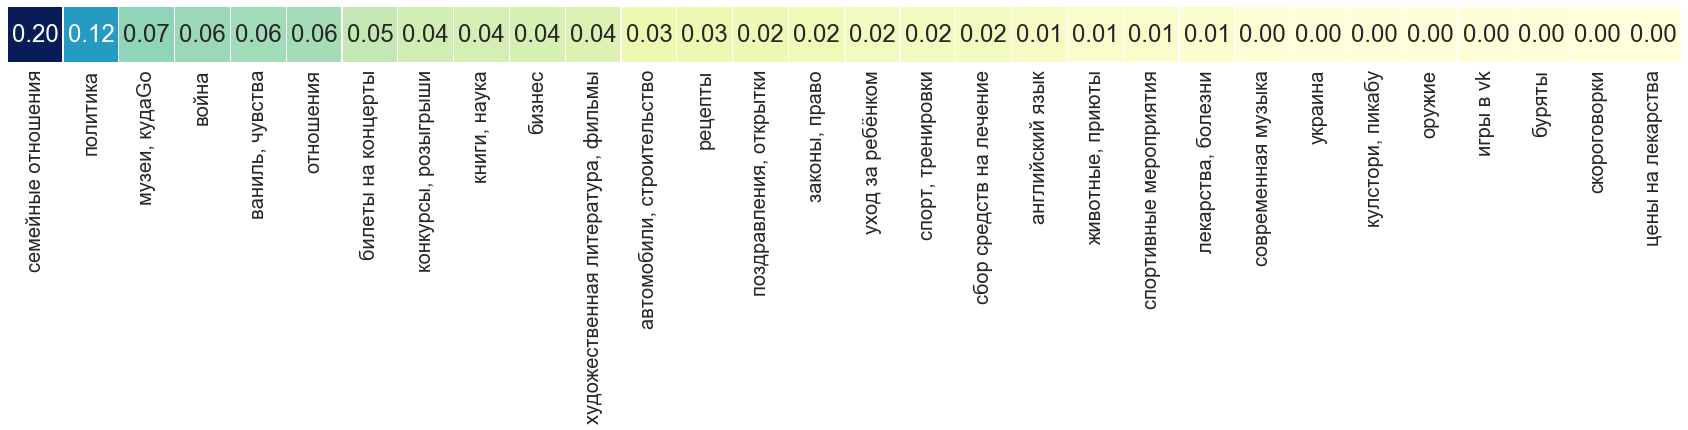

In [140]:
profilePlot(candidate_themes, 'Yavlinskiy')

Тематический профиль для Suraykin: 



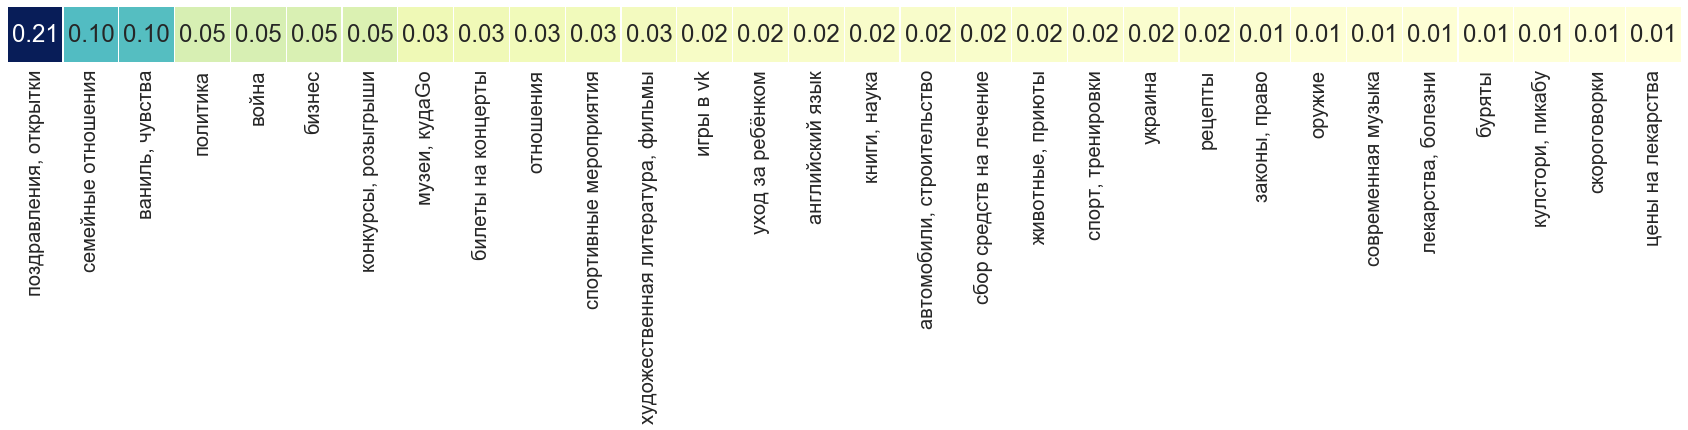

In [141]:
profilePlot(candidate_themes, 'Suraykin')

Тематический профиль для Titov: 



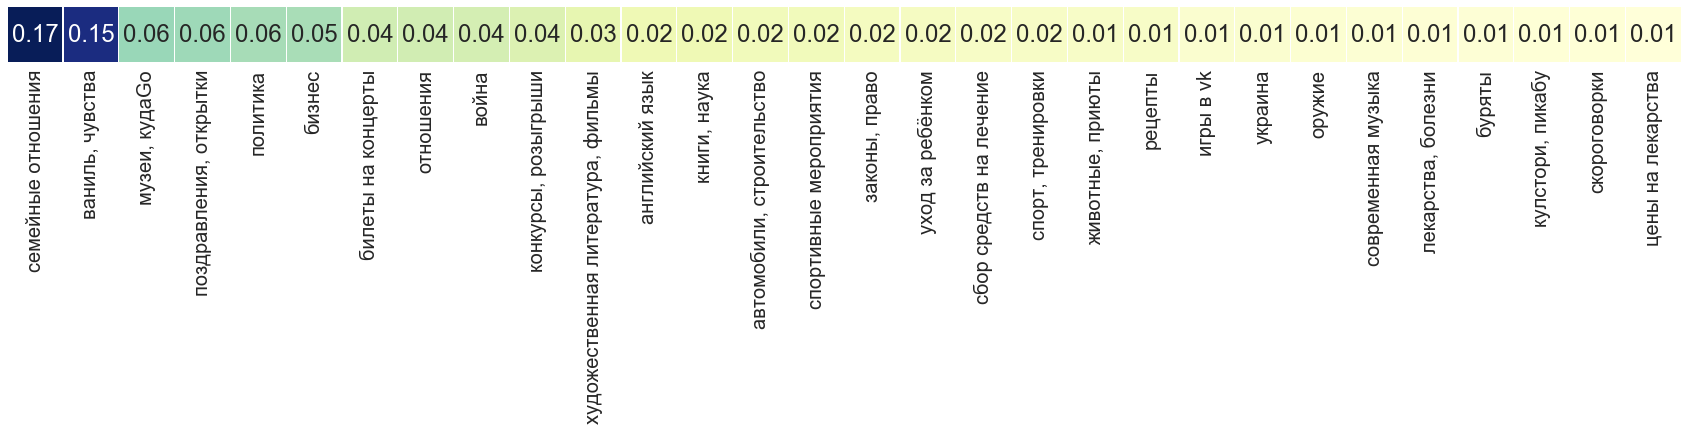

In [142]:
profilePlot(candidate_themes, 'Titov')

Тематический профиль для Baburin: 



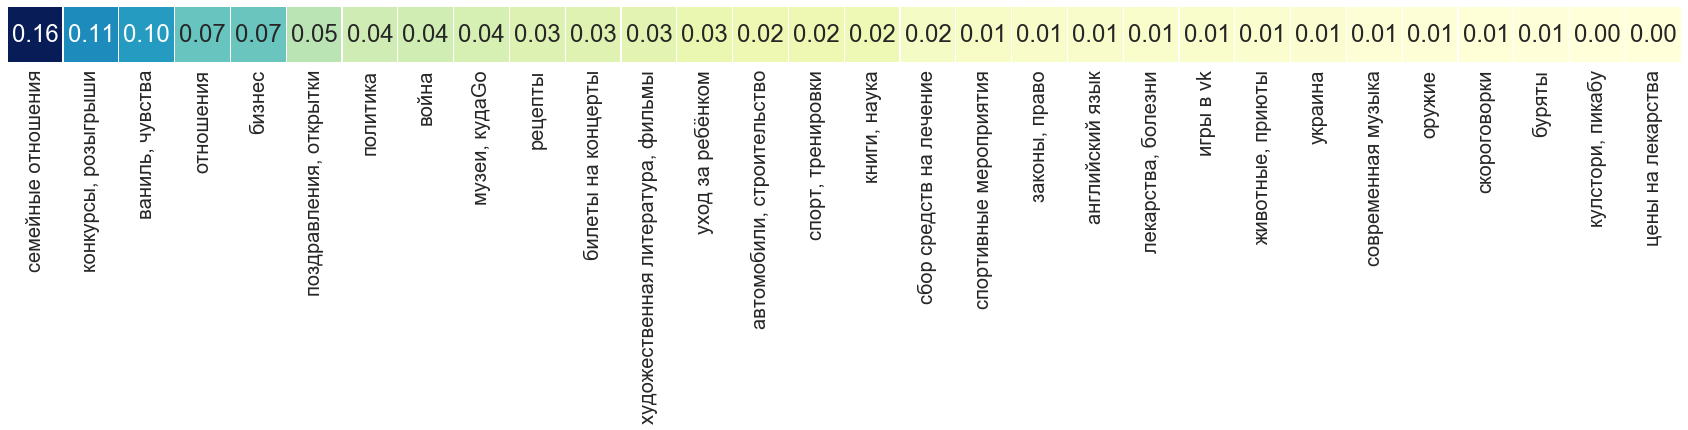

In [143]:
profilePlot(candidate_themes, 'Baburin')

## 5. Близость подписчиков разных кандидатов

In [159]:
candidates = list(candidate_themes.keys())
n = len(candidates)  # выясняем число кандидатов
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in candidate_themes[candidates[i]]]     # выделяем вектор для первого кандидата
    for j in range(n):
        can_2 = [item[1] for item in candidate_themes[candidates[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние. Почему косинусное? 
                                      # Просто оно классное! 

Построим матрицу расстояний и узнаем кто из кандидатов на кого похож по числу подписчиков. 

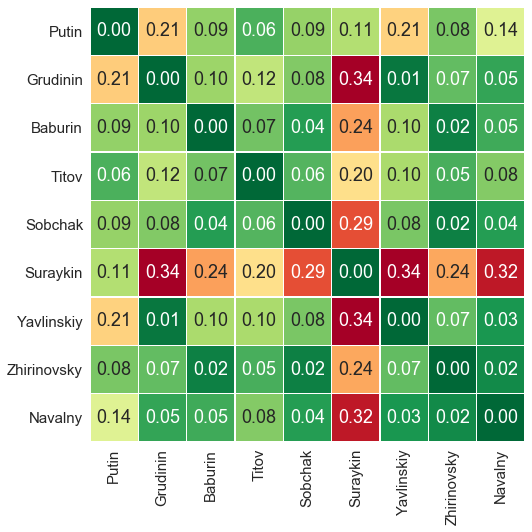

In [165]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(8, 8))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=candidates, xticklabels=candidates,cbar=False)